In [3]:
%matplotlib inline
import numpy as np
from scipy.interpolate import griddata
import math
from utils import pdb_parser, get_phi, get_psi, get_chi1, get_chi2, get_omega, split_pdb
from j_dft_int import load, compute_1j
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as  pm
import os
np.random.seed(10)

In [4]:
one_letter_code = {'CYS': 'C', 'ASP': 'D', 'SER': 'S', 'GLN': 'Q', 'LYS': 'K',
     'ILE': 'I', 'PRO': 'P', 'THR': 'T', 'PHE': 'F', 'ASN': 'N', 'HIS': 'H', 'LEU': 'L', 'ARG': 'R', 'TRP': 'W', 
     'ALA': 'A', 'VAL':'V', 'GLU': 'E', 'TYR': 'Y', 'MET': 'M'}#'GLY': 'G',
residues = list(one_letter_code.keys())
path='EXP_1j' #EXP_1j # cambiá esto a lo que vos tenías!
directory = os.listdir(path)
directory = ['1j8q.pdb', '1qh7_000.pdb', '1pjx.pdb', '1ubq.pdb', '1ekg.pdb', '9rnt.pdb']
lenght = len(directory)

In [5]:
# #List comprehension
# theol = dict()
# expl = dict()

# for file in range(lenght):  
    
#     filename = os.path.splitext(directory[file])[0]
#     tl = np.genfromtxt('alineadas/theoretical_data/{}.txt'.format(filename))[:,-1]
#     el = np.genfromtxt('alineadas/experimental_data/{}.txt'.format(filename))[:,-1]
#     r, coord = pdb_parser('{}/{}'.format(path, directory[file]))
    
#     tl = tl[el != 999.99]
#     #el = el[el != 999.99]
    
#     #tl = tl[~np.isnan(tl)]
#     el = el[~np.isnan(tl)]
    
#     for a in residues:
#         res_tl = [tl[i] for i in range(len(tl)) if r[i] == a ]
#         if a not in theol:
#             theol[a] = res_tl 
#         else:
#             theol[a].extend(res_tl)           

#         res_el = [el[i] for i in range(len(el)) if r[i] == a ]
#         if a not in expl:
#             expl[a] = res_el
#         else:
#             expl[a].extend(res_el)

In [6]:
# ##list c
# plt.figure(figsize=(27, 19))
# for i, resi in enumerate(residues):
#     plt.subplot(4, 5, i+1)
#     plt.title(resi)
#     plt.xlim(120, 160)
#     sns.kdeplot(np.array(theol[resi]), label = 'Theoretical', gridsize=1000)
#     sns.kdeplot(np.array(expl[resi]), label = 'Experimental', gridsize=1000)
#     plt.legend(loc='best')
# plt.savefig('kde_exp_theo_byres_listc.png')

In [7]:
#Pandas dfs
theo = dict()
exp = dict()

for file in range(lenght):  
    
    filename = os.path.splitext(directory[file])[0]
    
    t = pd.read_csv('alineadas/theoretical_data/{}.txt'.format(filename), header=None, names=['Res','J'], delim_whitespace=True)
    #t = t.dropna()    
    e = pd.read_csv('alineadas/experimental_data/{}.txt'.format(filename), header=None, names=['Res','J'], delim_whitespace=True)
    e = e.replace(to_replace=999.99, value=np.NAN)
    #e = e.dropna()    
    e = e[pd.notnull(t['J'])]
    t = t[pd.notnull(t['J'])]
    
    t = t[pd.notnull(e['J'])]
    e = e[pd.notnull(e['J'])]
    
    for a in residues:
        res_t = t[t['Res'] == a]
        if a not in theo:
            theo[a] = res_t['J']
        else:
            theo[a] = pd.concat((theo[a], res_t['J']), axis= 0 , ignore_index= True)
        
        res_e = e[e['Res'] == one_letter_code[a]]
        if a not in exp:
            exp[a] = res_e['J']
        else:
            exp[a] = pd.concat((exp[a], res_e['J']), axis= 0 , ignore_index= True)

In [9]:
for res in residues:    
    print(res, len(theo[res])-len(exp[res]))

HIS 0
ALA 0
CYS 0
VAL 0
GLU 1
THR -2
PRO 0
ARG 0
LEU 0
PHE 2
ASN 0
LYS 0
ASP 0
SER 0
TRP 0
ILE 0
TYR 0
GLN 0
MET 0


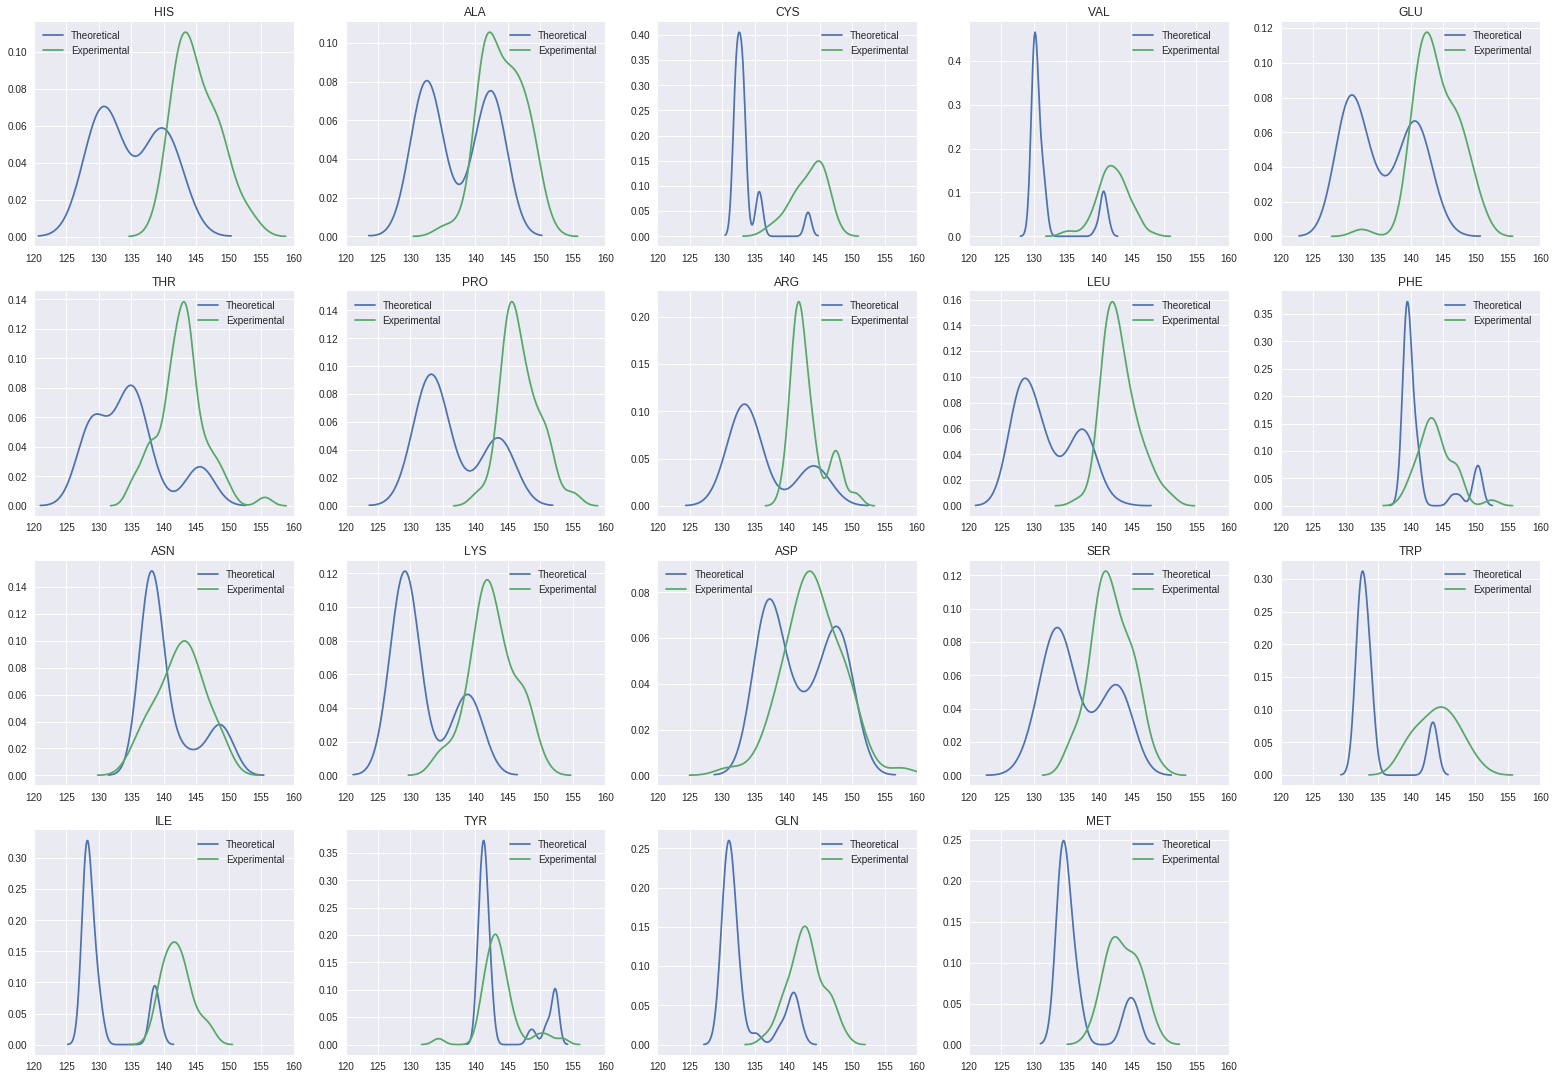

In [10]:
#pd dfs
plt.figure(figsize=(27, 19))
for i, resi in enumerate(residues):
    plt.subplot(4, 5, i+1)
    plt.title(resi)
    plt.xlim(120, 160)
    sns.kdeplot(theo[resi], label = 'Theoretical')
    sns.kdeplot(exp[resi], label = 'Experimental')
    plt.legend(loc='best')
plt.savefig('kde_exp_theo_byres.png')

In [29]:
# aminoacids = {'asn':5, 'ala':3, 'ile':5, 'his':5, 'met':5, 'arg':5, 
#  'thr':4, 'phe':5, 'cys':5, 'lys':5, 'glu':5, 'gln':5, 
#  'leu':5, 'ser':4, 'trp':5, 'tyr':5, 'val':4, 'asp':5, 'pro':2}
aminoacids = {'ala':3, 'ile':5, 'his':5, 'met':5, 'arg':5, 
 'thr':4, 'cys':5, 'lys':5, 'glu':5, 'gln':5, 
 'leu':5, 'ser':4, 'trp':5, 'val':4, 'asp':5, 'pro':2}


In [30]:
def d2f(x):
    return float(x.replace('D+', 'E+'))

In [31]:
labels = ['Φ', 'Ψ', 'χ1', 'χ2', 'χ3' ]

In [32]:
aa='ala'
j1 = pd.read_csv('data/{}_1J'.format(aa), header=None, names=['1J'], converters={'1J':d2f})
j1.shape

(491, 1)

In [33]:
tor= pd.read_fwf('data/TOR_{}'.format(aa), 
                 header=None, 
                 widths=[8]*aminoacids[aa], 
                 usecols=list(range(aminoacids[aa])), 
                 dtype=int)
tor.columns = labels[:aminoacids[aa]]
tor.head()

,Φ,Ψ,χ1
0,-180,-180,179
1,-180,120,179
2,-180,130,179
3,-180,140,179
4,-180,150,179


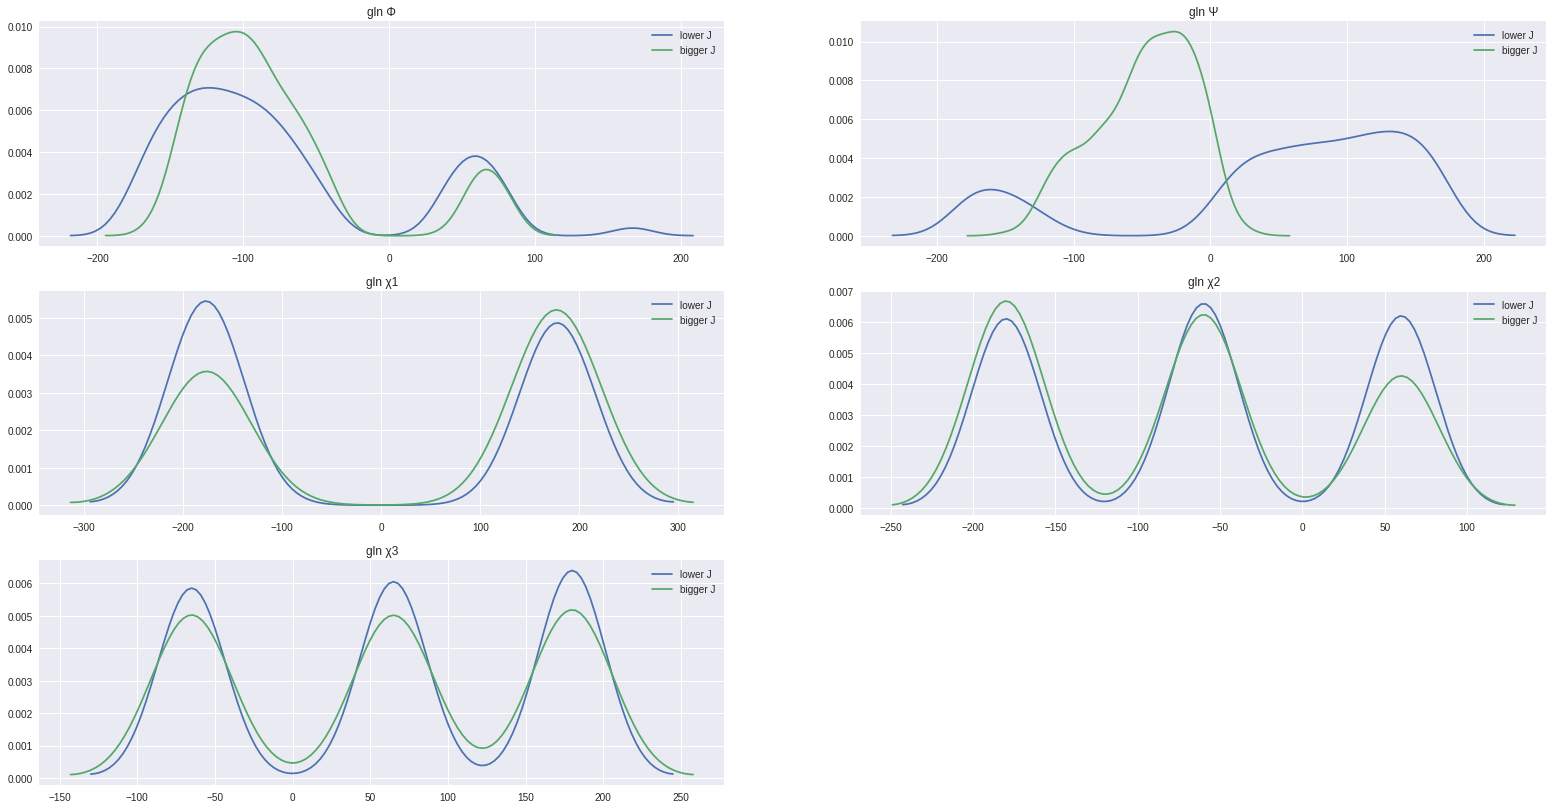

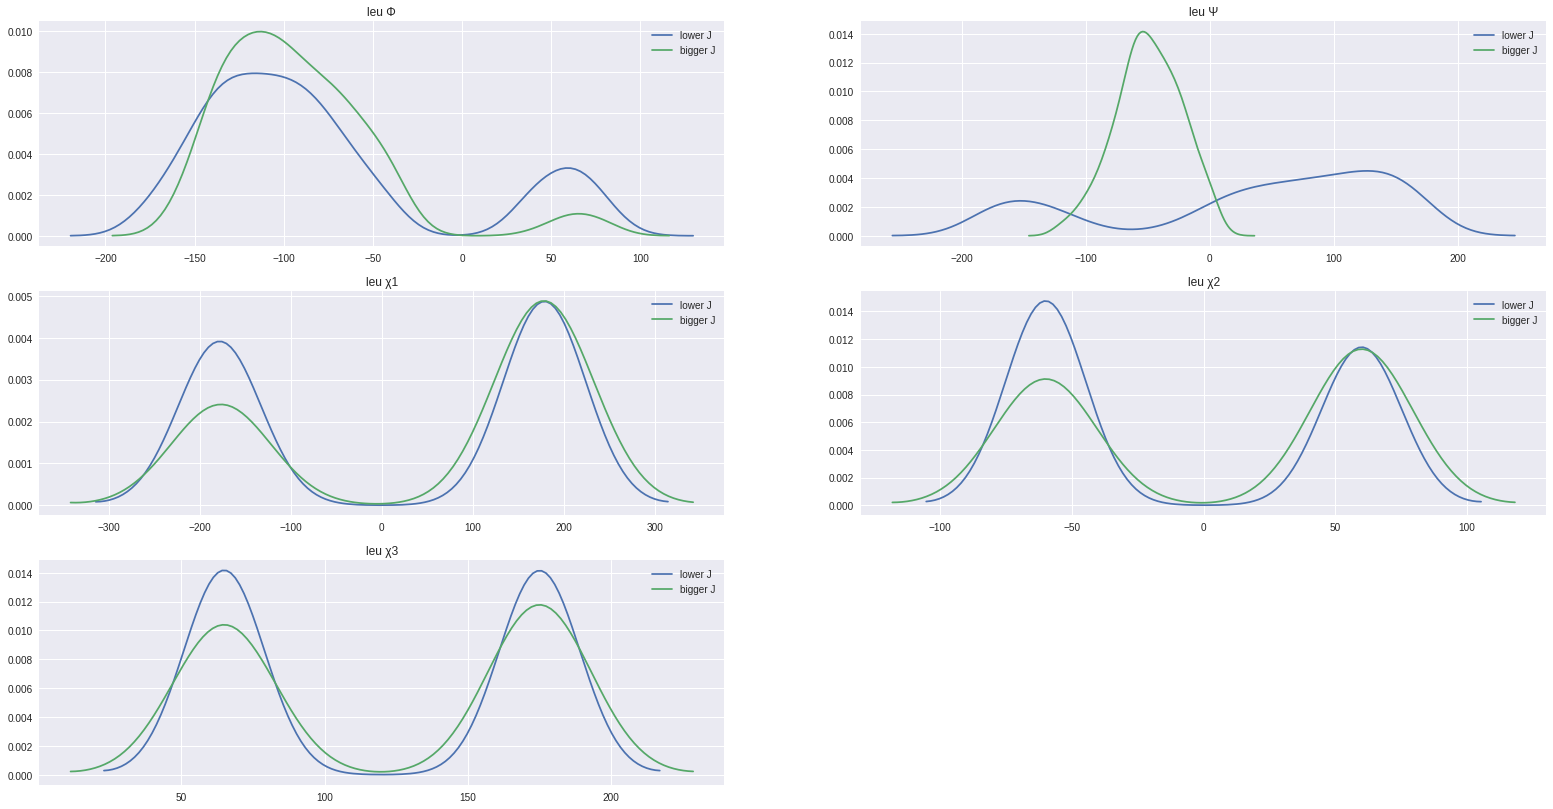

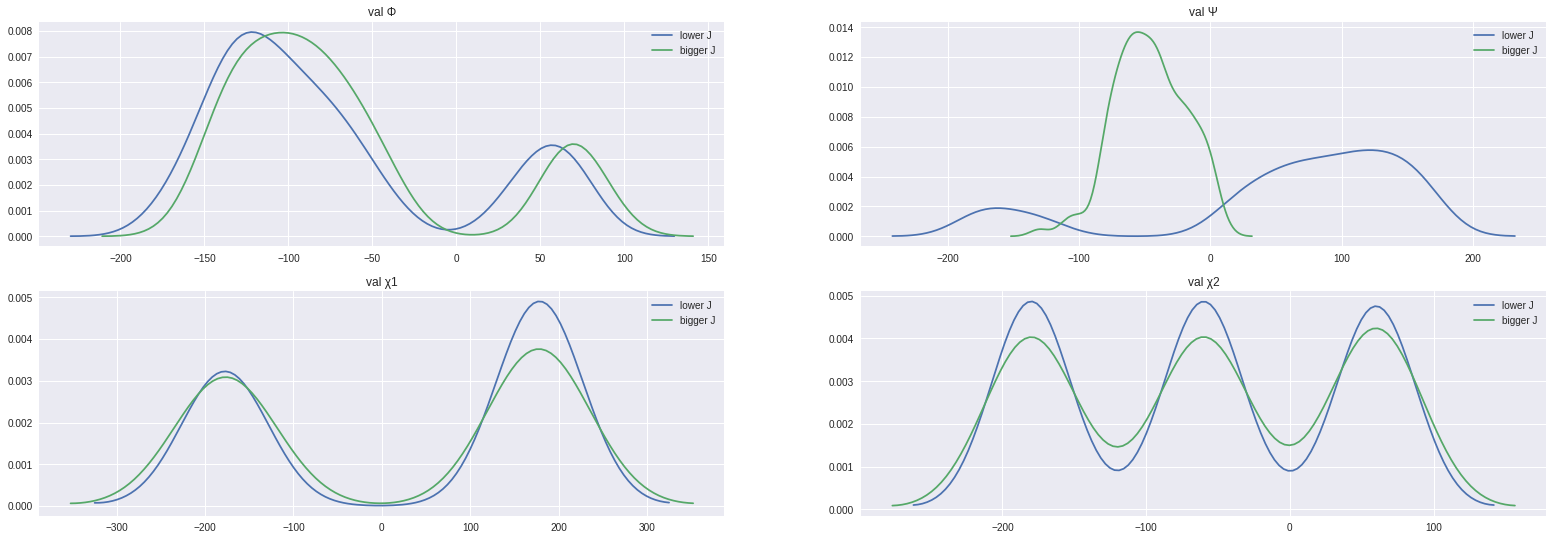

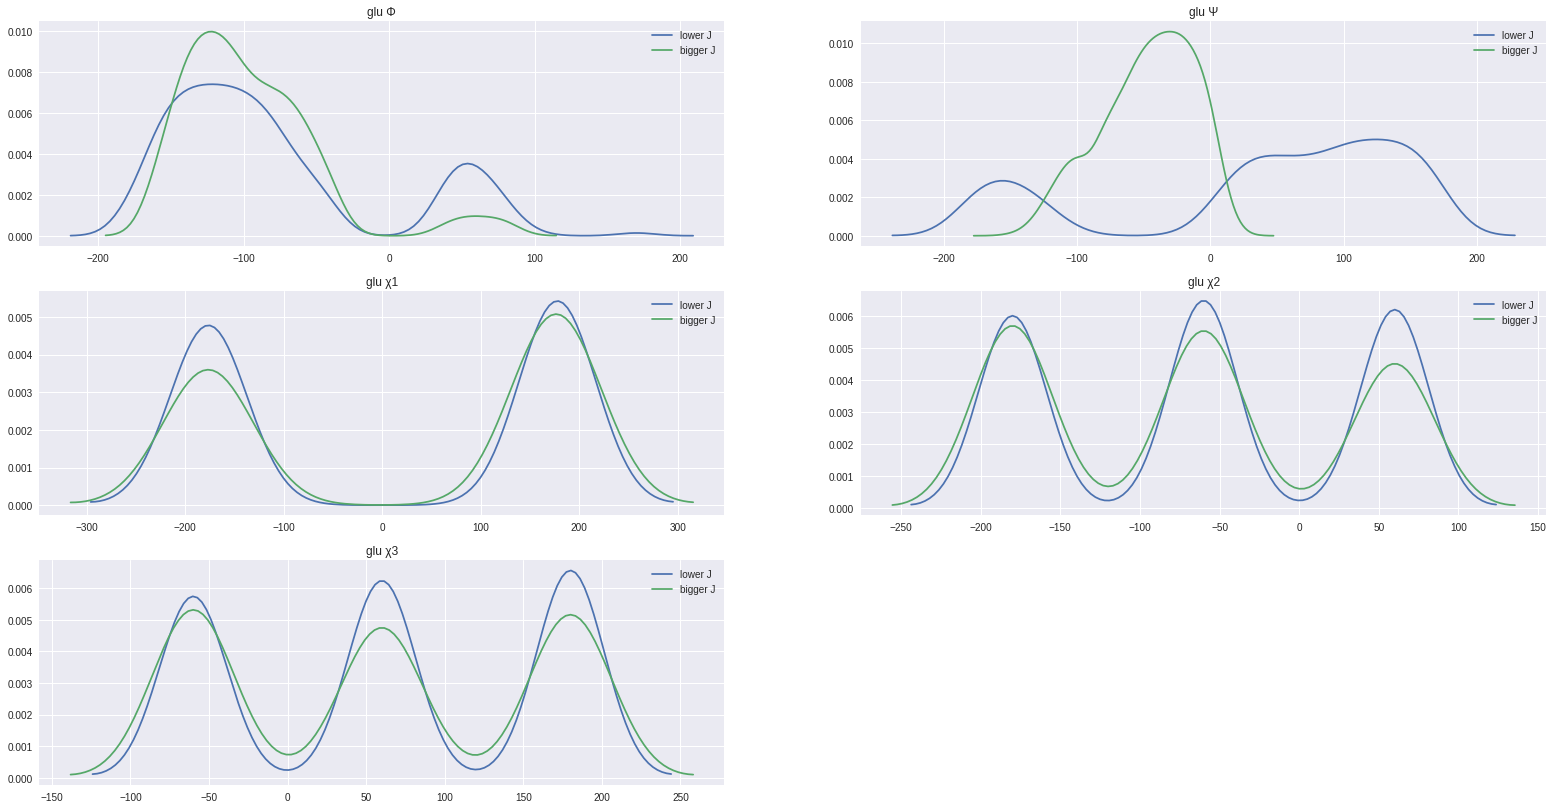

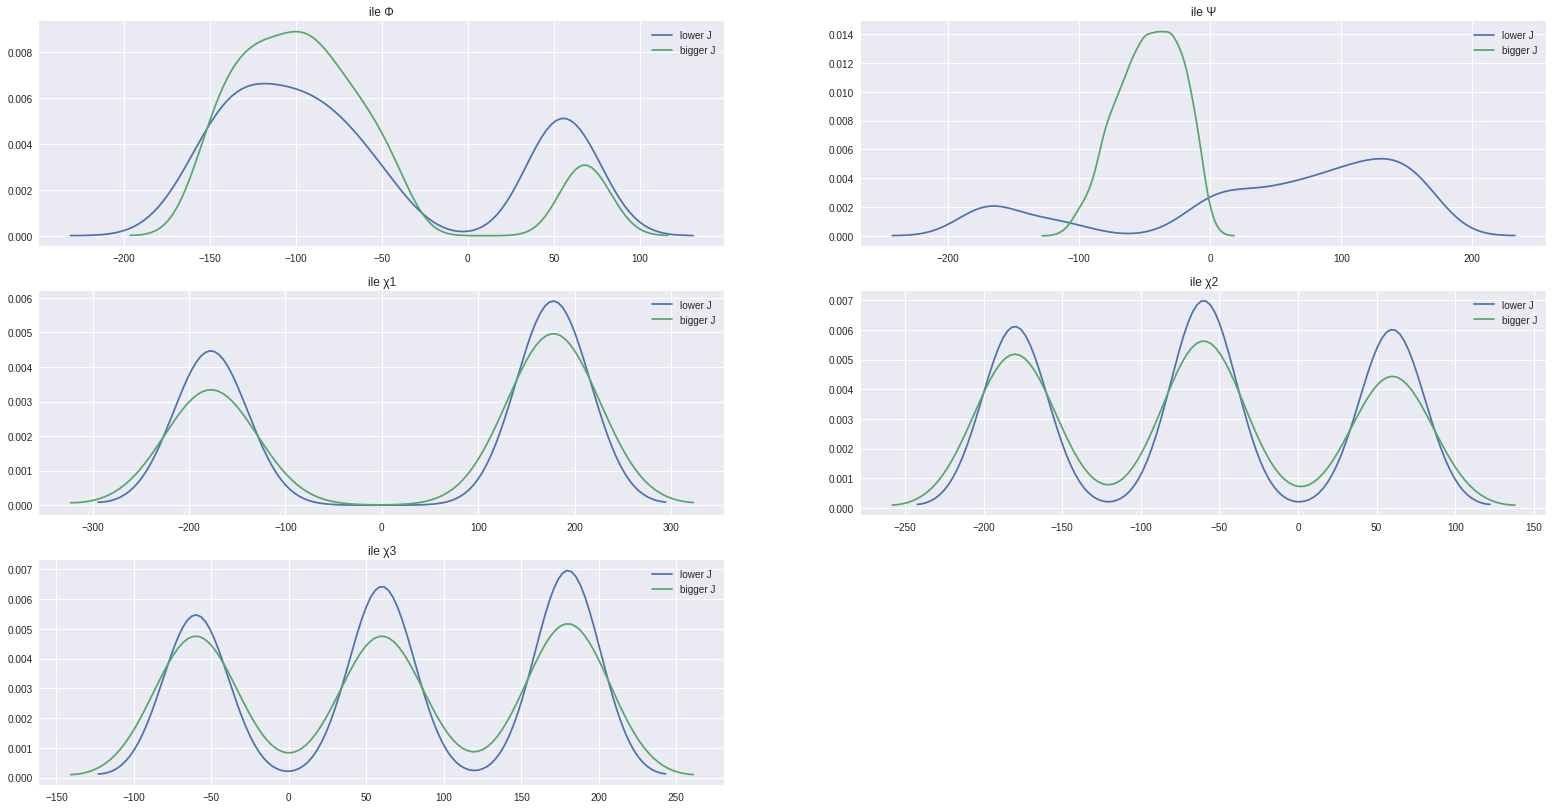

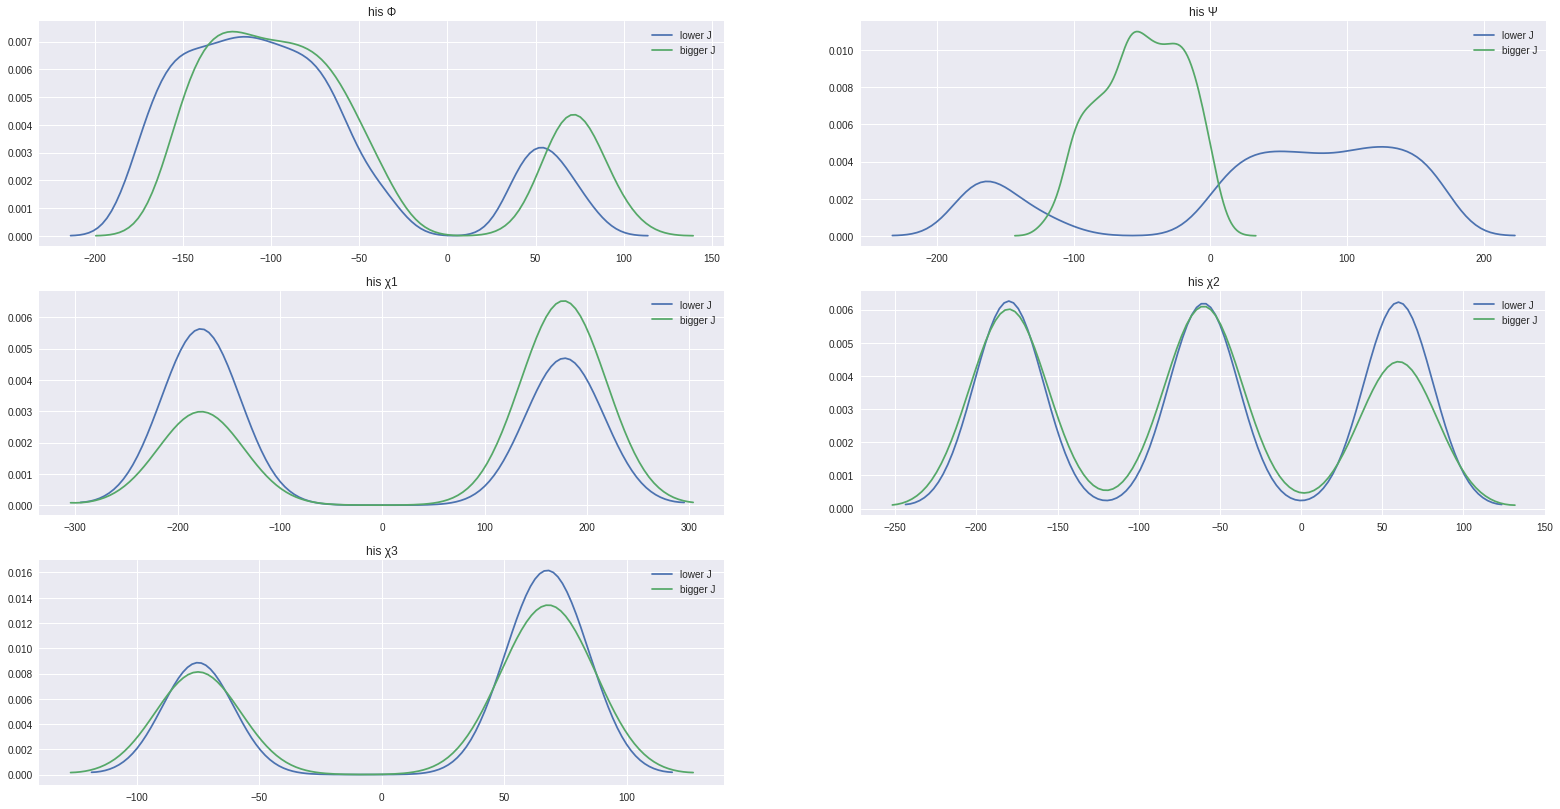

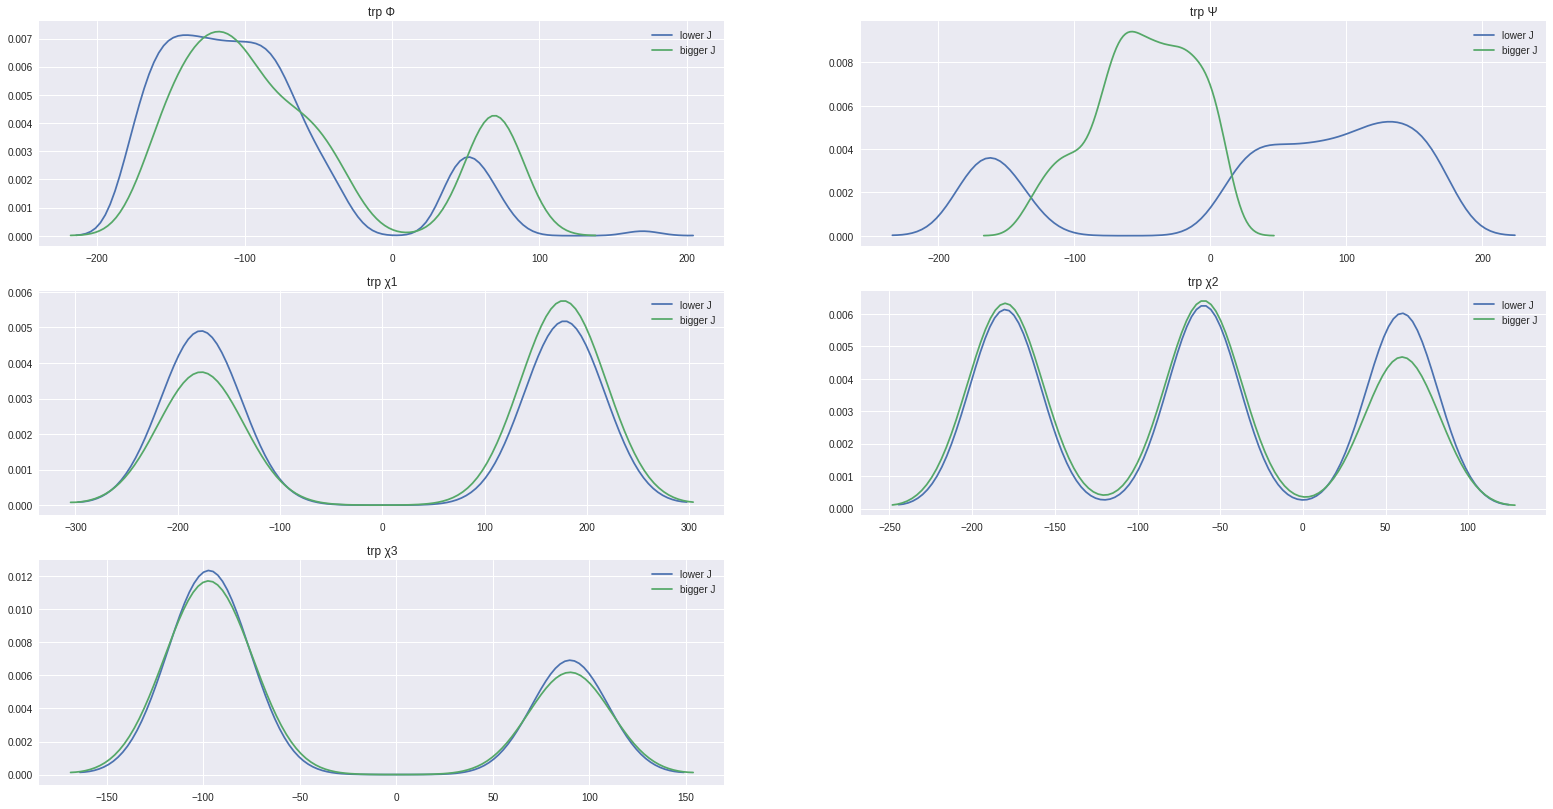

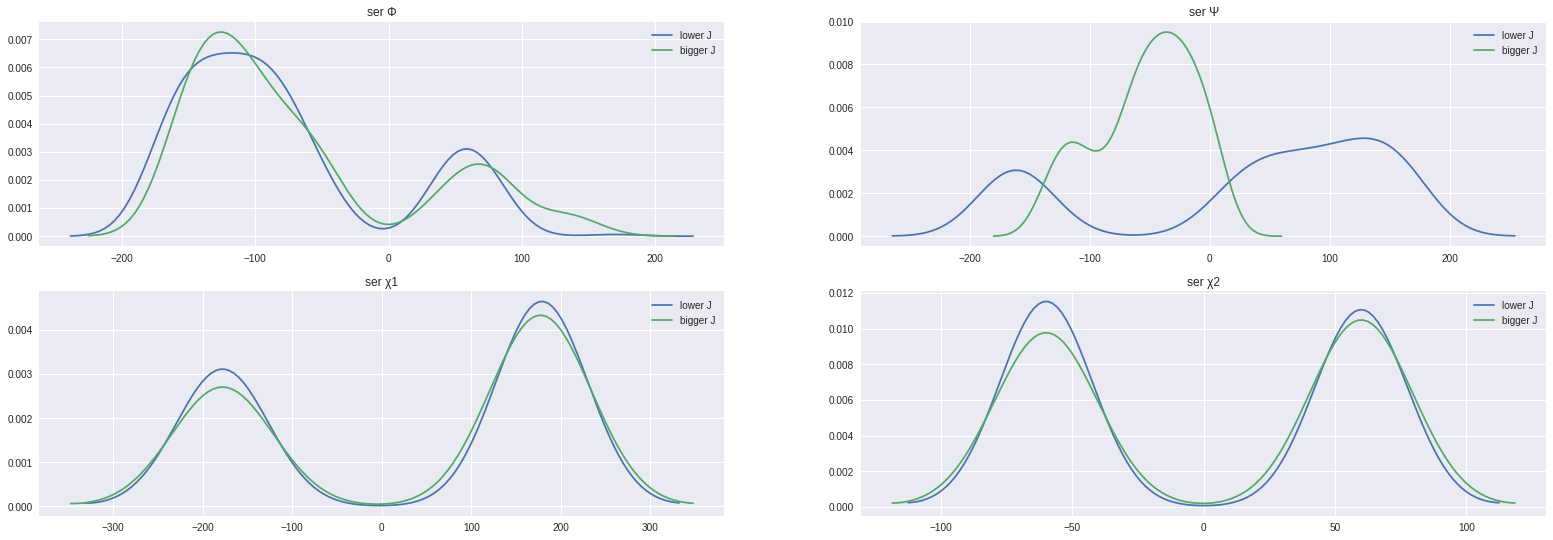

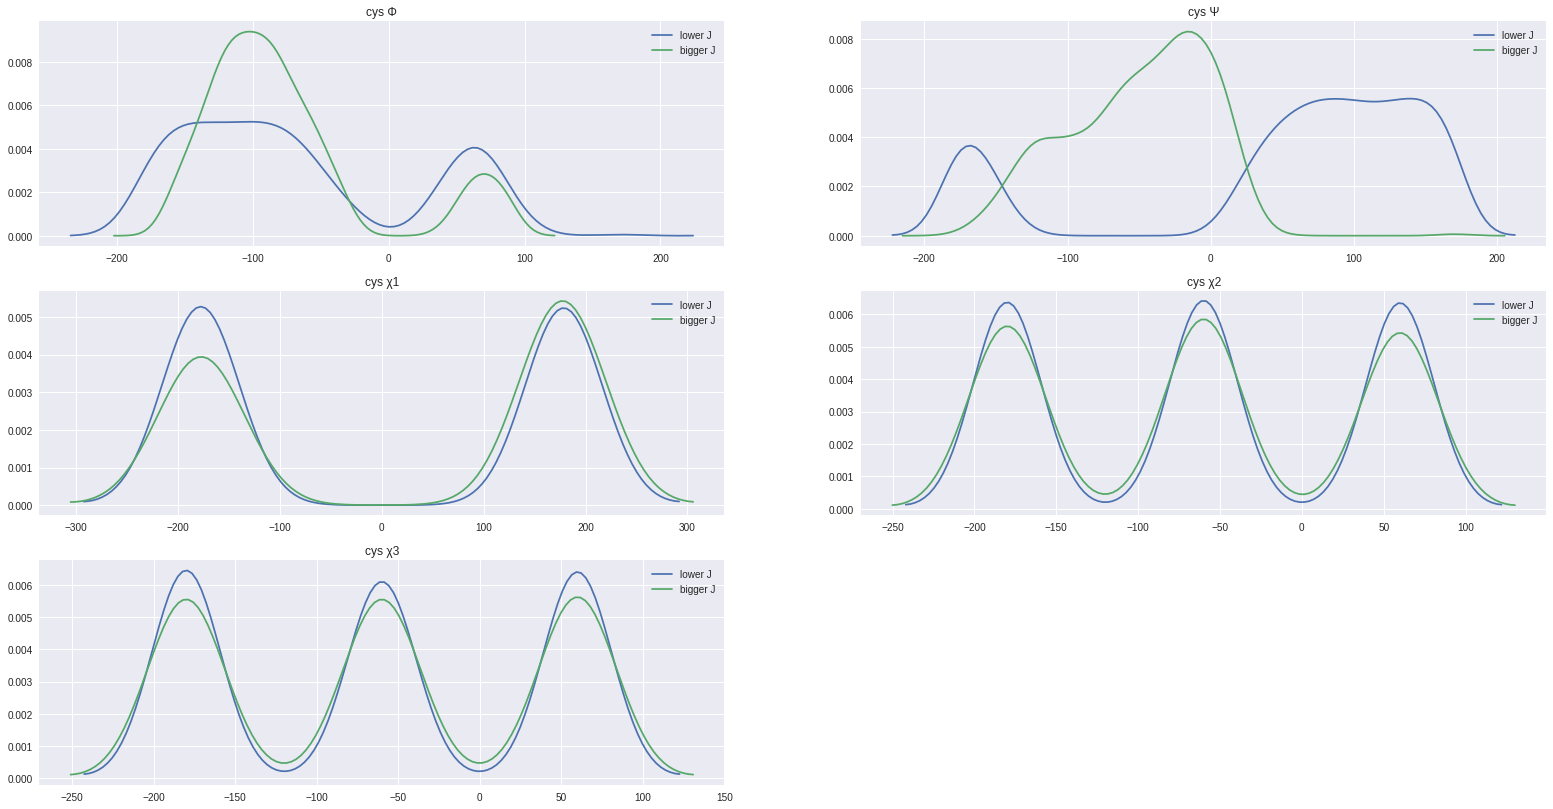

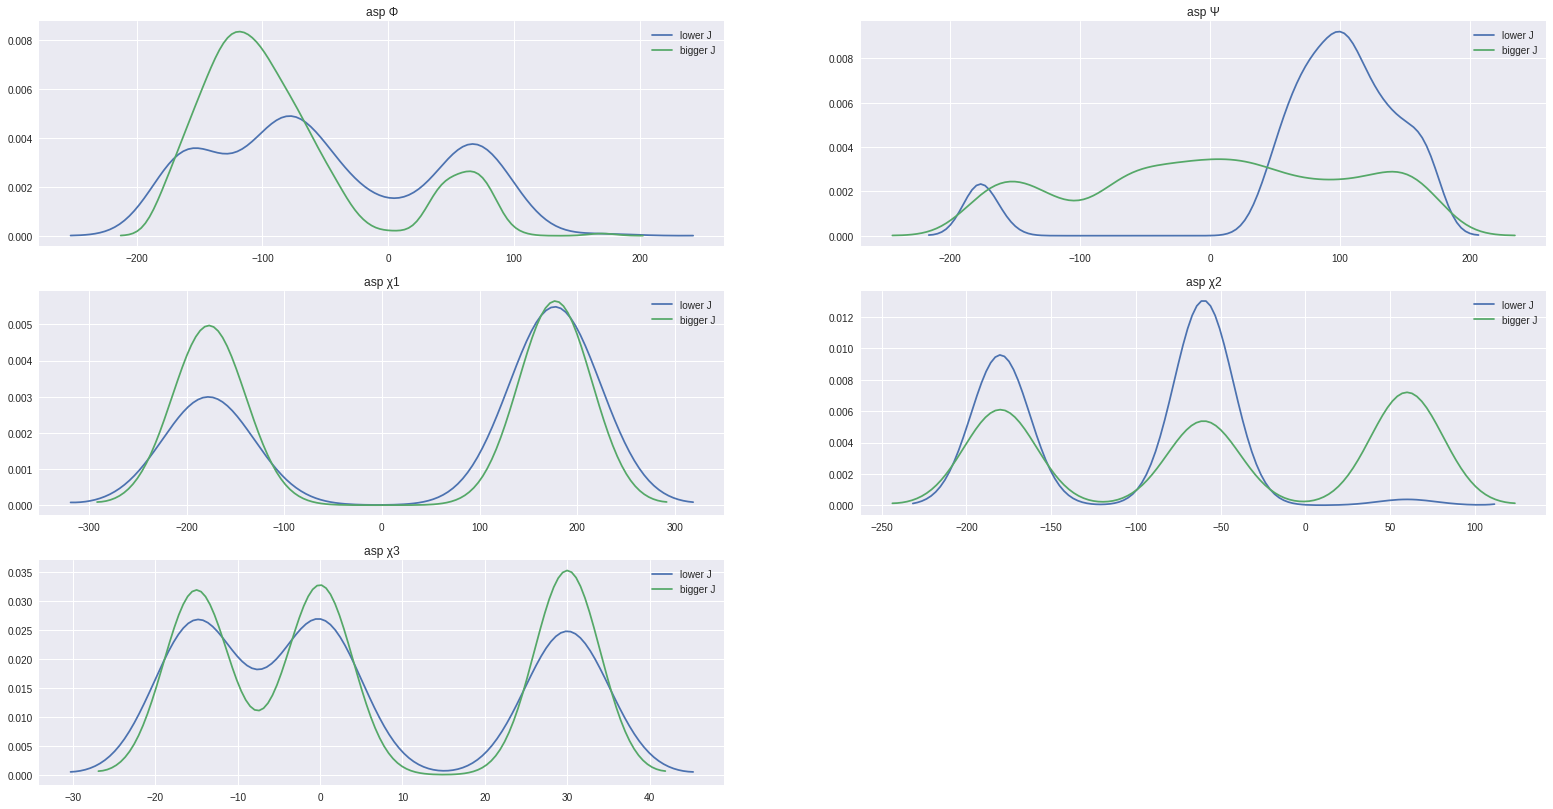

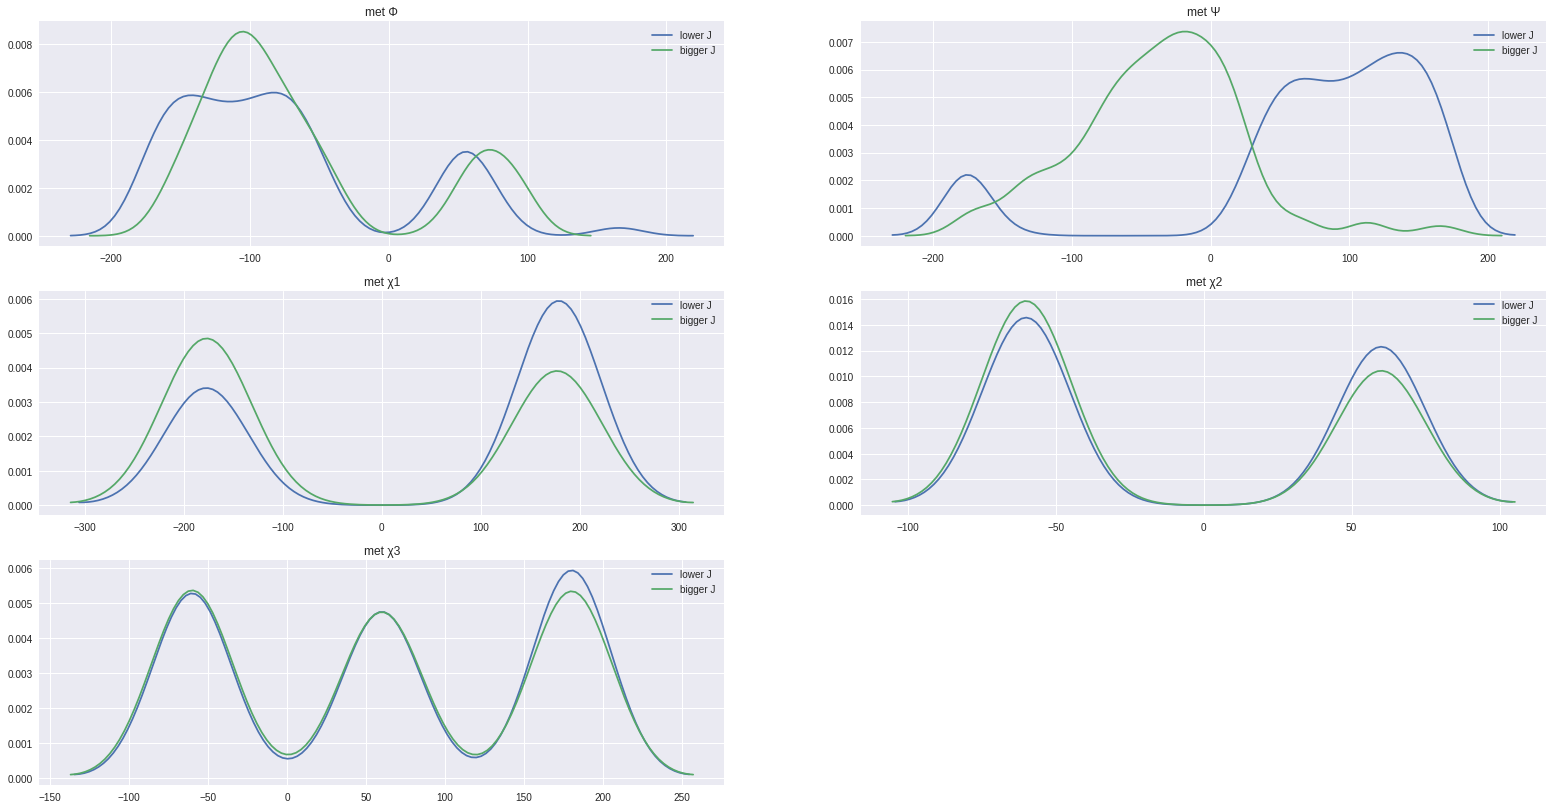

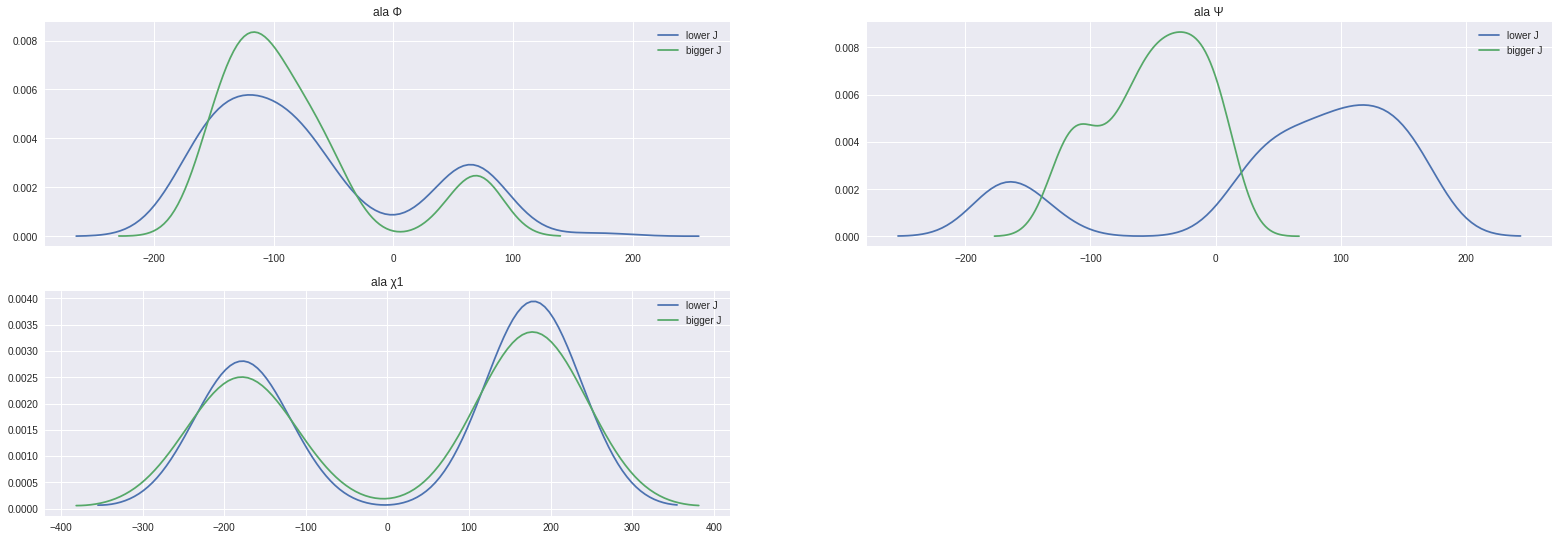

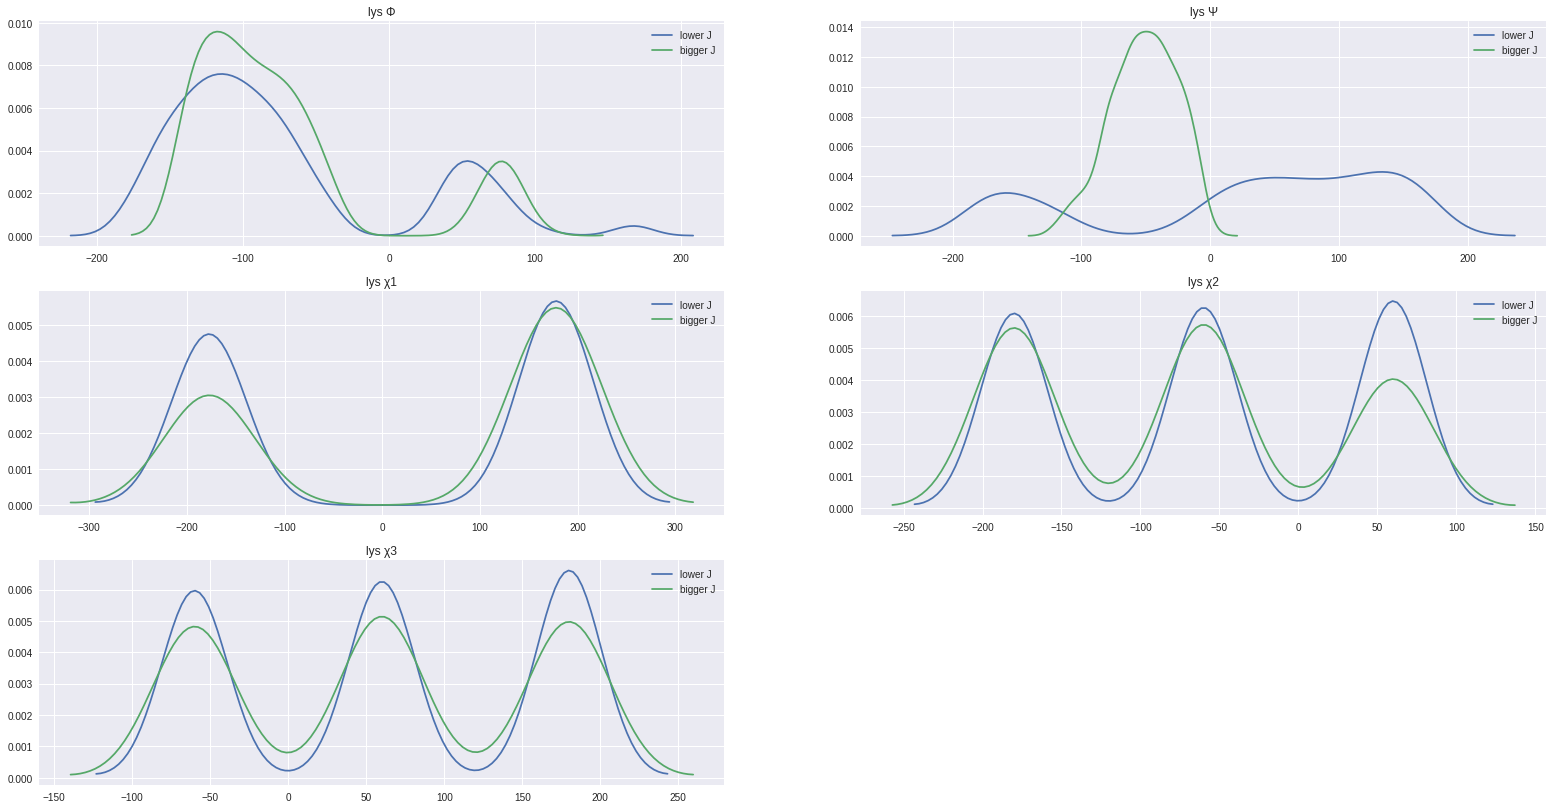

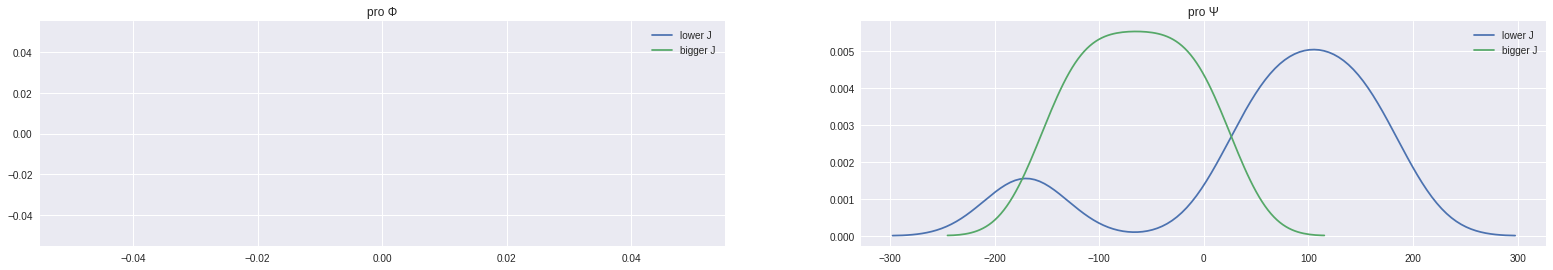

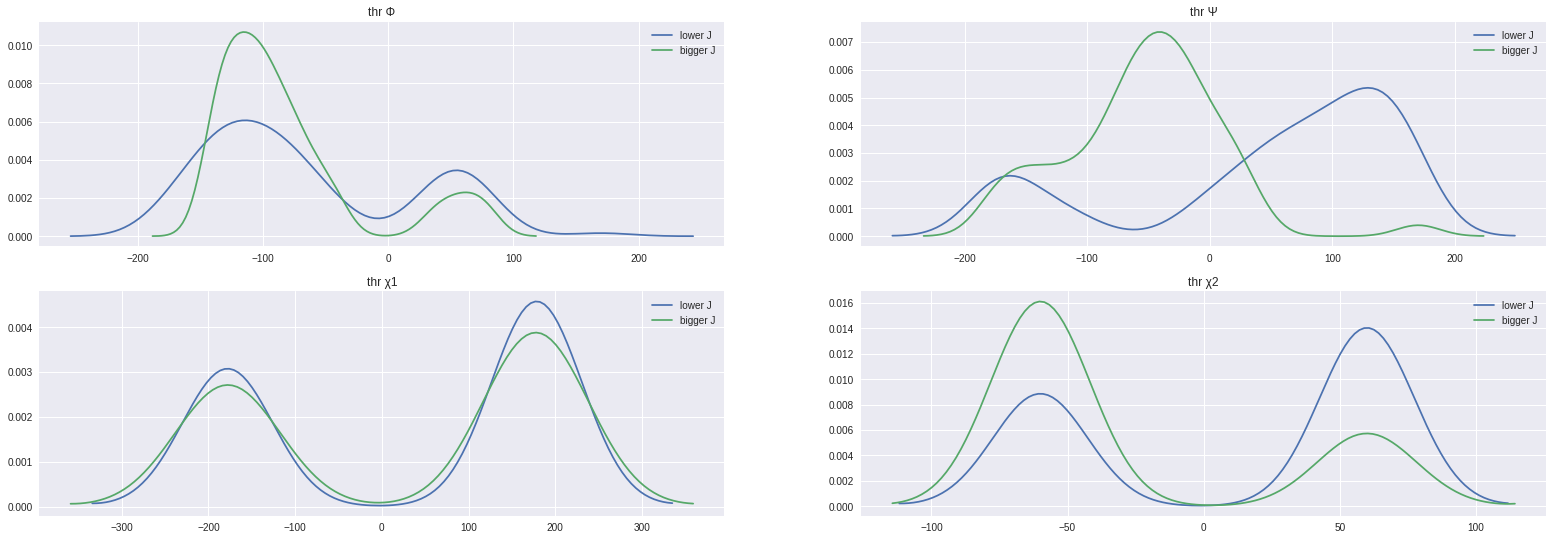

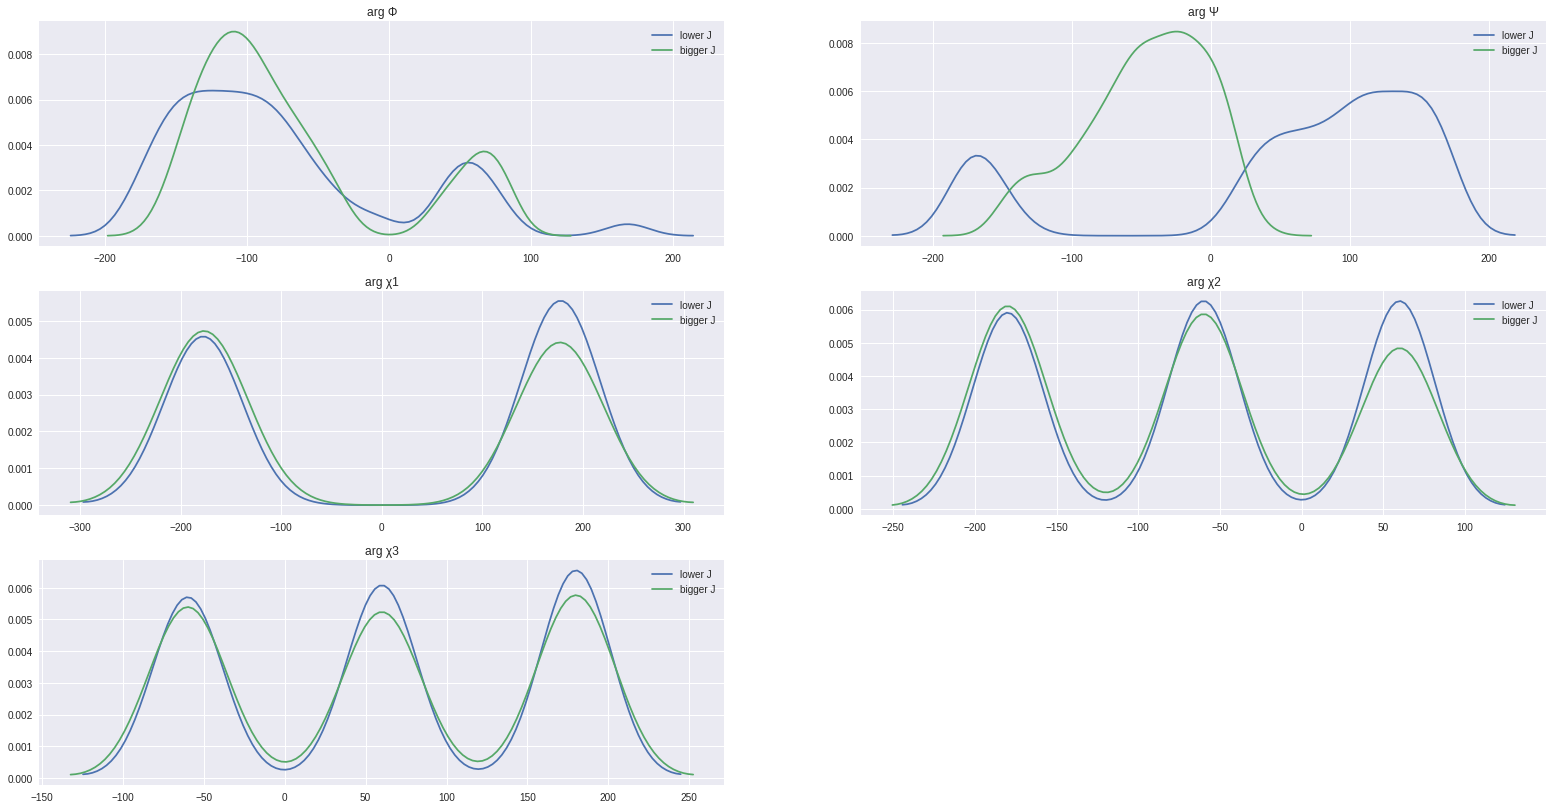

In [36]:
for e, aa in enumerate(aminoacids):
    j1 = pd.read_csv('data/{}_1J'.format(aa), header=None, names=['1J'], converters={'1J':d2f})
    tor= pd.read_fwf('data/TOR_{}'.format(aa), 
                 header=None, 
                 widths=[8]*aminoacids[aa], 
                 usecols=list(range(aminoacids[aa])), 
                 dtype=int)
    tor.columns = labels[:aminoacids[aa]]
    plt.figure(figsize=(27, 19))
    for i, tors in enumerate(tor.columns):
        plt.subplot(4, 2, i+1)
        plt.title('{} {}'.format(aa,tors))
        #sns.kdeplot(gln_tor[tor])
        #plt.xlabel('{} torsional angle value'.format(tors))
        sns.kdeplot(tor[tors][j1['1J']<=137], label = 'lower J')
        sns.kdeplot(tor[tors][j1['1J']>137], label = 'bigger J')
        plt.legend(loc='best')
    plt.savefig('plots_tor/kde_tor_{}.png'.format(aa))